In [1]:
!pip install swig
!pip install gymnasium[classic_control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 4.6 MB/s eta 0:00:00


In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from torch.utils.data import DataLoader, TensorDataset


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils as torch_utils
import numpy as np

env = gym.make("MountainCar-v0");
env._max_episode_steps = 1000
# seed = np.random.randint(5000)



In [51]:
seed = 4372

In [52]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
generator = torch.Generator().manual_seed(seed)
env.action_space.seed(seed)

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [53]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc3(x))
        x = self.fc2(x)
        return x

state, info = env.reset(seed = seed)
input_size = len(state)
hidden_size = 32
output_size = env.action_space.n
learning_rate = 0.001
# clip_value = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleClassifier(input_size, hidden_size, output_size).to(device)
crite = nn.CrossEntropyLoss()
opti = optim.Adam(model.parameters(), lr=learning_rate)
model.to(device)


SimpleClassifier(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)

In [54]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


#
#


class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

#
#



In [55]:
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

In [56]:
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)

memory = ReplayMemory(50000)

steps_done_Policy = 0
steps_done_Neural = 0
steps_done = 0;

def select_action(state, nn_action):
    global steps_done,steps_done_Policy , steps_done_Neural
    sample = random.random()
    if(nn_action):
      steps_done = steps_done_Neural
    else:
       steps_done = steps_done_Policy
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if(nn_action):
      steps_done_Neural+=1
    else:
      steps_done_Policy+=1
    if sample > eps_threshold:
        with torch.no_grad():
            if (not nn_action):
              return policy_net(state).max(1).indices.view(1, 1)
            else:
                neural_list = model(state)
                neural_probs = torch.softmax(neural_list, dim=1)
                categorical_dist = torch.distributions.categorical.Categorical(neural_probs)
                action = categorical_dist.sample()
                return torch.tensor([[action.item()]], device=device, dtype=torch.long)
                # return model(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [57]:
neural_epi = -995    # LunarLander
num_epoch = 60
neural_data = []
final_neural_data = []

episode_durations = []    #policy network
episode_durations2 = []   #NN


trained = False
uncertainity_period = False
First_trained = -1
converge = False
converge_step = -1
uncertainity_end = False
uncertainity_episode = -1


def plot_durations(episode , show_result=False):
    global uncertainity_period,First_trained,converge,converge_step,uncertainity_once
    global uncertainity_episode, uncertainity_end

    plt.figure(1)

    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    durations2_t = torch.tensor(episode_durations2, dtype=torch.float)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Duration')

    plt.plot(durations_t.numpy(), color='red', label='Policy Net')

    if(First_trained!=-1):
        end_index = min(First_trained + len(durations2_t), len(durations_t))
        plt.plot(range(First_trained, end_index), durations2_t[:end_index - First_trained].numpy(), color='blue', label='Neural Network')

    plt.legend()

    if((not uncertainity_period) and (not uncertainity_end)):
      if len(durations_t) >= 5 and len(durations2_t) >= 5:
          if all(d1< d2 for d1, d2 in zip(durations_t[-5:], durations2_t[-5:])):
              uncertainity_period = True
              uncertainity_episode = episode

    if uncertainity_period:
      if len(durations_t) >= 15 and len(durations2_t) >= 15:
          if all(d1> d2 for d1, d2 in zip(durations_t[-15:], durations2_t[-15:])):
              uncertainity_period = False
              uncertainity_end = True


    if len(durations_t) >= 10 :
      if durations_t[-10:].mean().item() >= -190:
          converge = True
          converge_step = len(durations_t)

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [58]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [59]:
if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 500

seed_array = [random.randint(1, 1000) for _ in range(num_episodes)]    #same initial state seeds for all episodes.

Complete


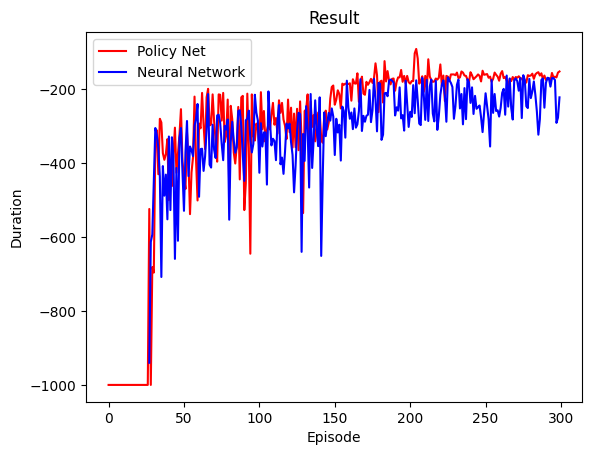

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [60]:
for i_episode in range(300):
    # if converge:
    #   print("Converge at step",converge_step)
    #   break

    #policy-net
    policy_rew = 0
    nn_rew = 0
    state, info = env.reset(seed = seed_array[i_episode])
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    neural_data.clear()


    for t in count():
        action = select_action(state,False)
        observation, reward, terminated, truncated, _ = env.step(action.item())


        reward = torch.tensor([reward], device=device)
        policy_rew+=reward

        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        if(not uncertainity_period):
            memory.push(state, action, next_state, reward)
        neural_data.append((state,action.item()))
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        if done:
            episode_durations.append(policy_rew)
            if (policy_rew >= neural_epi and (not uncertainity_end)):

                if(not trained):
                  trained = True
                  First_trained = i_episode


                final_neural_data.extend(neural_data[-200:])  # Extend final_neural_data with tuples of inputs and labels
                neural_epi = max(neural_epi, policy_rew)


                for epoch in range(20):
                      random.shuffle(neural_data)
                      for inputs, label in neural_data[-200:]:
                            inputs = inputs.to(device)
                            target = torch.tensor(label, dtype=torch.long).unsqueeze(0).to(device)
                            outputs = model(inputs)
                            loss = crite(outputs, target)
                            opti.zero_grad()
                            loss.backward()
                            opti.step()
                for epoch in range(num_epoch-20):
                      random.shuffle(final_neural_data)
                      for inputs, label in final_neural_data[-1000:]:
                            inputs = inputs.to(device)
                            target = torch.tensor(label, dtype=torch.long).unsqueeze(0).to(device)
                            outputs = model(inputs)
                            loss = crite(outputs, target)
                            opti.zero_grad()
                            loss.backward()
                            opti.step()
            break

    #neural-network
    if(trained and (not uncertainity_end)):
        neural_data.clear()
        nn_rew = 0
        state_n, info = env.reset(seed = seed_array[i_episode])
        state_n = torch.tensor(state_n, dtype=torch.float32, device=device).unsqueeze(0)
        for t in count():
          action = select_action(state_n,True)
          observation, reward, terminated, truncated, _ = env.step(action.item())

          reward = torch.tensor([reward], device=device)

          nn_rew+=reward

          done = terminated or truncated
          if terminated:
              next_state = None
          else:
              next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
          if(uncertainity_period):
            memory.push(state_n, action, next_state, reward)
          neural_data.append((state_n,action.item()))

          state_n = next_state
          if done:
              episode_durations2.append(nn_rew)
              if nn_rew >= neural_epi:
                  neural_epi = max(neural_epi, nn_rew)
                  final_neural_data.extend(neural_data[-200:])  # Extend final_neural_data with tuples of inputs and labels


                  for epoch in range(20):
                      random.shuffle(neural_data)
                      for inputs, label in neural_data[-200:]:
                            inputs = inputs.to(device)
                            target = torch.tensor(label, dtype=torch.long).unsqueeze(0).to(device)
                            outputs = model(inputs)
                            loss = crite(outputs, target)
                            opti.zero_grad()
                            loss.backward()
                            opti.step()
                  for epoch in range(num_epoch-20):
                      random.shuffle(final_neural_data)
                      for inputs, label in final_neural_data[-1000:]:
                            inputs = inputs.to(device)
                            target = torch.tensor(label, dtype=torch.long).unsqueeze(0).to(device)
                            outputs = model(inputs)
                            loss = crite(outputs, target)
                            opti.zero_grad()
                            loss.backward()
                            opti.step()
              neural_data.clear()
              break
    # list1.append(nn_rew-policy_rew)
    plot_durations(i_episode)



print('Complete')
plot_durations(0,show_result=True)
plt.ioff()
plt.show()

In [61]:
print(len(episode_durations))

300


In [62]:
uncertainity_period

False

In [63]:
file_path = str(seed) + "_NN.txt"
with open(file_path, "w") as file:
    for index, item in enumerate(episode_durations):
        file.write(f"{index},{item}\n")

In [64]:
file_path = str(seed) + "_NN.txt"
file_path

'4372_NN.txt'

In [65]:
for i in range(11, len(episode_durations)):
    mean_val = np.mean(episode_durations[i-10:i])
    if mean_val >= -190:
        print(i)
        break

165
